# IHFA - Índice de Hedge Funds ANBIMA

O IHFA (Índice de Hedge Funds ANBIMA) é uma referência para a indústria de hedge funds. No Brasil, esses produtos se assemelham aos fundos multimercado de gestão ativa, com aplicações em diversos segmentos do mercado e várias estratégias de investimento.

O índice conta com os fundos mais representativos do segmento em sua carteira e pPara garantir a representatividade, o IHFA é ajustado trimestralmente, seguindo os seguintes critérios qualitativos e quantitativos:

- Seleção apenas dos fundos multimercados que estejam enquadrados nessa classe há mais de um ano.
- Exclusão dos fundos fechados, dos exclusivos e daqueles que não cobram taxa de performance.
- Exclusão dos fundos com número médio de cotistas inferior a dez no trimestre anterior à data de rebalanceamento.
- Exclusão dos fundos que não divulgam o valor das cotas atualizadas diariamente.

O objetivo desta análise é verificar os retornos, volitilidade e outras estatísticas dos fundos presente no índice.

Input files:
- IHF_TEORICO.csv: https://www.anbima.com.br/pt_br/informar/consulta-ihfa.htm
- data.xlsx: preencher manualmente

Fontes:
- Histórico IHFA: https://inva.capital/brasil/wp-content/uploads/sites/4/2020/07/2020-07.pdf
- Histórico CDI e IPCA: https://www.debit.com.br/tabelas/tabela-completa.php?indice=cdi
- Histórico IBOV, IFIX e Dólar: https://br.investing.com/

Output files:
- Ano de origem dos fundos: fundos_por_ano.png
- Fundos mais antigos: fundos_mais_antigos.png
- Relação Retorno x Volatilidade: retorno-vol.png
- Indicadores: retorno_tabela.png

TODO:
- Obter dados do IHFA desde mai/2008 (origem do índice). Até o momento só possuo desde de nov/2012

In [204]:
import pandas as pd
from pandas.plotting import table 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import six
from requests import Session
import json
from glob import glob
import datetime
%matplotlib inline

# Extrair fundos da carteira teórica do índice

In [205]:
ihf = pd.read_csv('input/IHF_TEORICO.csv',encoding='latin1', sep=';', skiprows=3)
ihf.drop('Data Início', axis=1, inplace=True)
ihf.drop('Data Final', axis=1, inplace=True)

Preparar valores numéricos e CNPJ

In [206]:
ihf.iloc[:,2:] = ihf.iloc[:,2:].apply(lambda x: x.str.replace('.',''))
ihf.iloc[:,2:] = ihf.iloc[:,2:].apply(lambda x: x.str.replace(',','.'))
ihf[ihf.columns[2:]] = ihf.iloc[:,2:].astype(float)

ihf.iloc[:,1:2] = ihf.iloc[:,1:2].apply(lambda x: x.str.replace('.',''))
ihf.iloc[:,1:2] = ihf.iloc[:,1:2].apply(lambda x: x.str.replace('/',''))
ihf.iloc[:,1:2] = ihf.iloc[:,1:2].apply(lambda x: x.str.replace('-',''))

Nova coluna da gestora do fundo

In [207]:
ihf.insert(0,'Asset','-')
ihf['Asset'] = ihf['Fundo'].str.split().str.get(0)

Ordenar pelo fundo com maior participação no índice

In [208]:
ihf.sort_values(by=['Participação Relativa (%)'], ascending=False, inplace=True)

# Obter perfomance histórica de cada fundo

In [209]:
def featch_url(cnpj):
    url = 'https://assets-comparacaodefundos.s3-sa-east-1.amazonaws.com/cvm/' + str(cnpj)
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:82.0) Gecko/20100101 Firefox/82.0',
        'Accepts': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
    }
    
    session = Session()
    session.headers.update(headers)
    response = session.get(url)
    return json.loads(response.text)

In [210]:
'''
JSON parser

JSON template:
    "c": rendimento
    "d": data
    "p": patrimonio liquido
    "q": cotistas
'''
def parse_data(fundo, data):
    df = pd.DataFrame(data)  
    df['d'] = pd.to_datetime(df['d'], format='%Y%m%d')
    df = df.set_index('d')
    
    #Normaliza valores e subtrai pelo primeiro valor
    df[fundo] = (df.c / df.c.iloc[0]) - 1
    df.fillna(0, inplace=True)
    
    #Filtra por mês com o valor do último dia do mês atual / valor do último dia do mês passado (1+Actual)/(1+Past)-1
    df = df.resample('M').last()
    df['mensal'] = (1+df[fundo])/(1+df[fundo].shift(1))-1
    
    df.drop(columns=['c','p','q'], inplace=True)
    return df

Cria diretório com performance de cada fundo do índice

In [211]:
for i in range(ihf.shape[0]):    
    df = parse_data(ihf['Fundo'][i],featch_url(ihf['CNPJ'][i]))
    df.to_excel('output/'+ihf['Asset'][i]+'_'+ihf['CNPJ'][i]+'.xlsx')        

# Calcular estatísticas

In [212]:
def cagr(returns):
    return ((returns + 1).cumprod() - 1).iloc[-1]

def vol(returns, n=12):
    return returns.std() * np.sqrt(n)

def cdi_perc(returns, rf):
    return cagr(returns)/cagr(rf)

def sharpe_ratio(returns, rf):
    return (cagr(returns) - cagr(rf)) / vol(returns)

def beta(returns, market):
    return np.cov(returns, market)[0][1] / np.var(market, ddof=1)

def treynor_ratio(returns, market, rf):
    return (cagr(returns) - cagr(rf)) / beta(returns, market)

def alpha_jensen(returns, market, rf):
    return (cagr(returns) - cagr(rf)) - beta(returns, market)*(cagr(market)-cagr(rf))

def corr(returns, market):
    return np.corrcoef(returns,market)[0][1]

def months_above_benchmark(returns, benchmark):
    return sum(returns>benchmark)/len(returns) 

def max_return(returns):
    return max(returns)

def min_return(returns):
    return min(returns)

def prices(returns, base):
    s = [base]
    for i in range(len(returns)):
        s.append(base * (1 + returns.tolist()[i]))
    return np.array(s)

def drawdown(returns, tau):
    values = prices(returns, 100)
    pos = len(values) - 1
    pre = pos - tau
    drawdown = float('+inf')
    while pre >= 0:
        dd_i = (values[pos] / values[pre]) - 1
        if dd_i < drawdown:
            drawdown = dd_i
        pos, pre = pos - 1, pre - 1
    return abs(drawdown)

def max_drawdown(returns):
    max_drawdown = float('-inf')
    for i in range(0, len(returns)):
        drawdown_i = drawdown(returns, i)
        if drawdown_i > max_drawdown:
            max_drawdown = drawdown_i
    return abs(max_drawdown)

def stress_test(returns):
    return returns.mean()-(3*vol(returns))

# Comparar dados

Filtro do período inicial da gestão e investidor alvo

In [213]:
start_date = '2012-11-01'

Obter índices de benchmark e carteiras 

In [214]:
rend = pd.read_excel('input/data.xlsx')

In [215]:
rend = rend[rend.iloc[:,0] >= start_date]

In [216]:
end_date = rend.dropna().tail(1).iloc[-1,0]

In [217]:
rend_indices = rend.drop(['IPCA','IHFA'], axis=1).dropna().set_index(rend.columns[0])
rend_ihfa = rend.drop(['CDI','IPCA','Dólar','Ibovespa','IFIX'], axis=1).dropna().set_index(rend.columns[0])

In [218]:
df_indices = pd.DataFrame() 
for i in range(rend_indices.shape[1]): 
    df_indices = df_indices.append(dict(zip(['Fundo','CAGR','VOL'],[rend_indices.columns[i], cagr(rend_indices.iloc[:,i]), vol(rend_indices.iloc[:,i])])), ignore_index=True)                                    

In [219]:
df_ihfa = pd.DataFrame() 
for i in range(rend_ihfa.shape[1]): 
    df_ihfa = df_ihfa.append(dict(zip(['Fundo','CAGR','VOL'],[rend_ihfa.columns[i], cagr(rend_ihfa.iloc[:,i]), vol(rend_ihfa.iloc[:,i])])), ignore_index=True)                                    

Obter dados dos fundos

In [220]:
pages = glob('output/*.xlsx')

In [224]:
def get_data_by_start_date(page, start_date):
    df = pd.read_excel(page)
    df = df[df.d >= start_date]
    df.rename(columns={df.columns[2]:df.columns[1]}, inplace=True)
    df = df.dropna().set_index(df.columns[0])  
    
    # ler somente 4 primeiras palavras do nome do fundo
    sub = df.columns[1].split()[0:4]
    name  = ' '.join(sub)
    return dict(zip(['Fundo','CAGR','VOL'],[name, cagr(df.iloc[:,1]), vol(df.iloc[:,1])]))

In [225]:
df_fundos = pd.DataFrame() 
dfs = [ get_data_by_start_date(page, start_date) for page in pages ]
df_fundos = df_fundos.append(dfs, ignore_index=True)

Listar fundos mais antigos di IHFA por ano

In [226]:
def get_data_by_year(page):
    df = pd.read_excel(page)
    df.drop('mensal', axis=1, inplace=True)
    df['d'] = df['d'].dt.strftime('%Y')
    return df.drop_duplicates(subset = ['d']).set_index(df.columns[0]) 

In [227]:
dfs = [ get_data_by_year(page) for page in pages ]
fundos_por_ano = pd.concat(dfs, axis=1, sort=True)

Ano de origem dos fundos

In [228]:
data = {'Fundos': fundos_por_ano.apply(lambda x: x.notnull().sum(), axis='columns')}
df_sts = pd.DataFrame(data=data)

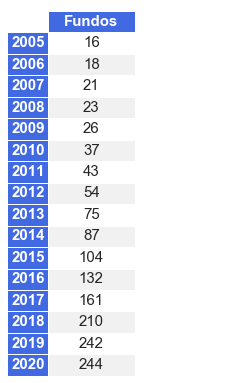

In [229]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

header_color = 'royalblue'
row_colors = ['#f1f1f2', 'w']

tab = table(ax, df_sts, loc='upper left', cellLoc='center', colWidths=[0.30]*len(df_sts.columns))

#properties
tab.auto_set_font_size(False)
tab.set_fontsize(15)
tab.scale(1.5, 1.5)

#coloring
for k, cell in six.iteritems(tab._cells):
    cell.set_edgecolor('w')

    if k[0] == 0 or k[1] < 0:
        cell.set_text_props(weight='bold', color='w')
        cell.set_facecolor(header_color)
    else:
        cell.set_facecolor(row_colors[k[0]%len(row_colors)])

plt.tight_layout()
plt.savefig('fundos_por_ano.png',dpi=300, bbox_inches = 'tight')

Quais são os mais antigos?

In [230]:
fundos_por_ano.loc[fundos_por_ano.index[0]].dropna().index
data = {fundos_por_ano.index[0]: fundos_por_ano.loc[fundos_por_ano.index[0]].dropna().index}
df_antigo = pd.DataFrame(data=data)

C:\Users\guilh\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


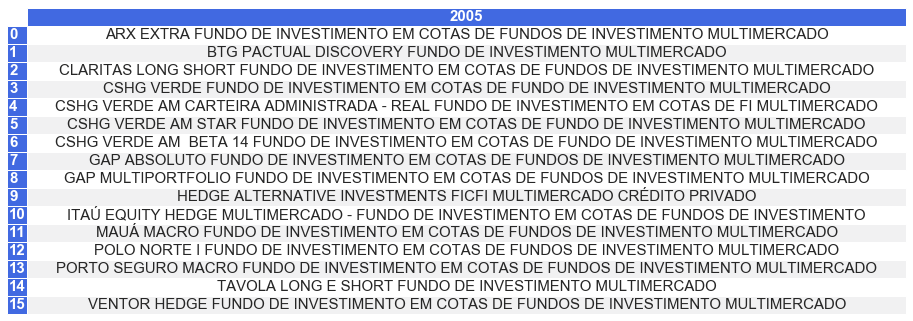

In [231]:
fig, ax = plt.subplots(figsize=(3, 1))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

header_color = 'royalblue'
row_colors = ['#f1f1f2', 'w']

tab = table(ax, df_antigo, loc='upper left', cellLoc='center', colWidths=[3.5]*len(df_antigo.columns))

#properties
tab.auto_set_font_size(False)
tab.set_fontsize(15)
tab.scale(1.5, 1.5)

#coloring
for k, cell in six.iteritems(tab._cells):
    cell.set_edgecolor('w')

    if k[0] == 0 or k[1] < 0:
        cell.set_text_props(weight='bold', color='w')
        cell.set_facecolor(header_color)
    else:
        cell.set_facecolor(row_colors[k[0]%len(row_colors)])

plt.tight_layout()
plt.savefig('fundos_mais_antigos.png',dpi=300, bbox_inches = 'tight')

Exibir resultados

In [232]:
df = pd.concat([df_fundos.assign(dataset='Fundos'),
                df_indices.assign(dataset='Índice'), 
                df_ihfa.assign(dataset='IHFA')], sort=True)

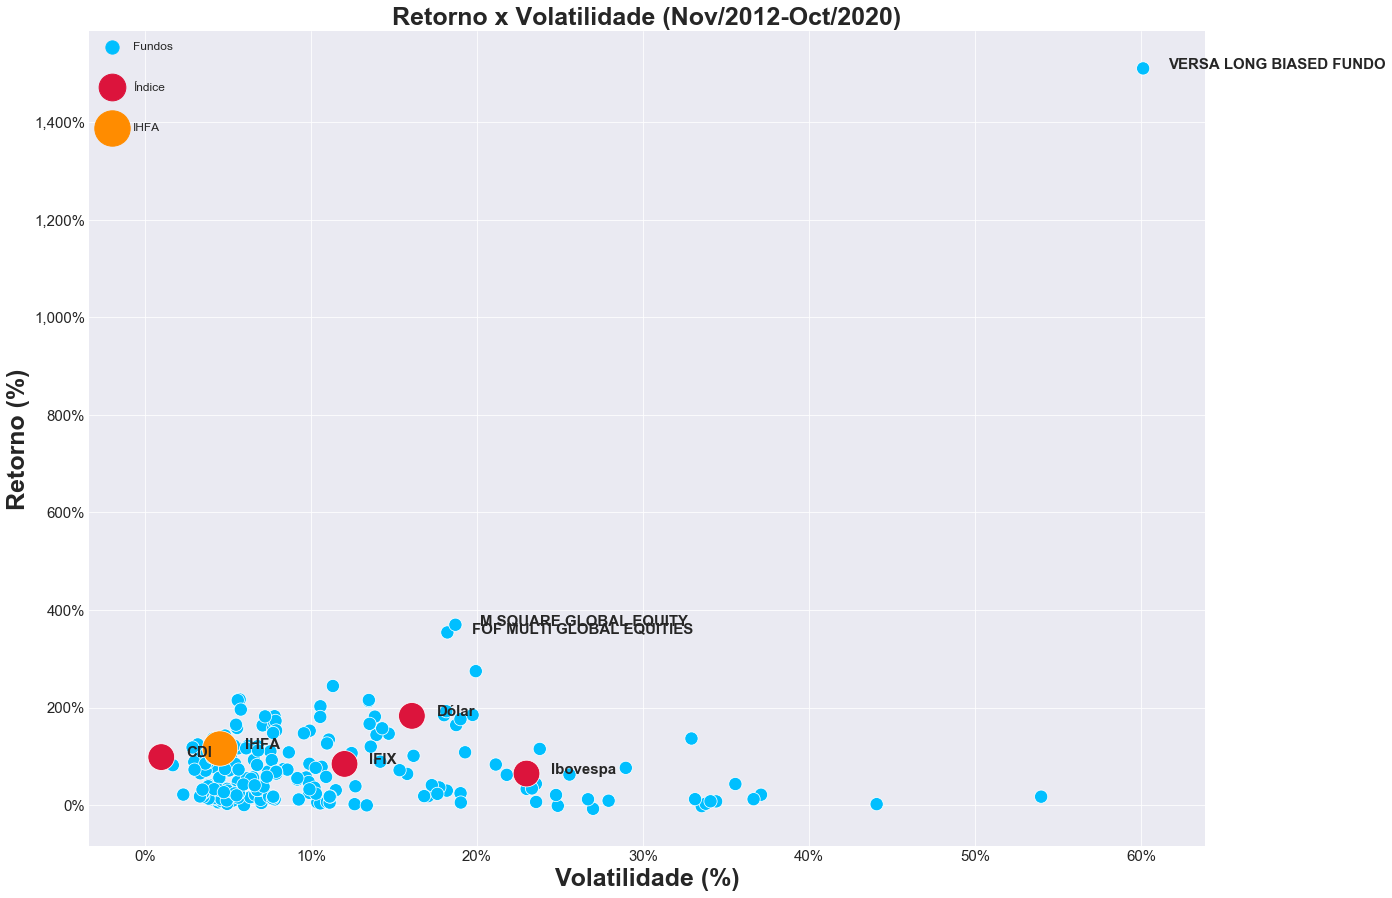

In [233]:
color = ['deepskyblue','crimson','darkorange']

fig, ax = plt.subplots(figsize=(20, 15))
s = sns.scatterplot(data=df, x='VOL', y='CAGR', hue='dataset', size='dataset',
                     sizes=(1250, 175), palette=color, ax=ax)

s_datee = datetime.datetime.strptime(start_date, "%Y-%m-%d")
period = str(s_datee.strftime("%b")) + '/' + str(s_datee.year) + \
         '-' + str(end_date.strftime("%b")) + '/' + str(end_date.year)

plt.title('Retorno x Volatilidade' + ' ('+period+')', fontsize=25, fontweight='bold')
plt.xlabel('Volatilidade (%)', fontsize=25, fontweight='bold')
plt.ylabel('Retorno (%)', fontsize=25, fontweight='bold')

vals = s.get_xticks()
s.set_xticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=15)
vals = s.get_yticks()
s.set_yticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=15)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], labelspacing=2.5, fontsize=12)

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)    

    for i, point in a.iterrows():
        ax.text(point['x']+.015, point['y'], str(point['val']), fontsize=15, fontweight='bold')

x = df[df['dataset'] == 'Fundos'].sort_values(by='CAGR', ascending=False).head(3).VOL
y = df[df['dataset'] == 'Fundos'].sort_values(by='CAGR', ascending=False).head(3).CAGR
val = df[df['dataset'] == 'Fundos'].sort_values(by='CAGR', ascending=False).head(3).Fundo
label_point(x, y, val, plt.gca()) 
        
x = df[df['dataset'] == 'Índice'].VOL
y = df[df['dataset'] == 'Índice'].CAGR
val = df[df['dataset'] == 'Índice'].Fundo            
label_point(x, y, val, plt.gca()) 

x = df[df['dataset'] == 'IHFA'].VOL
y = df[df['dataset'] == 'IHFA'].CAGR
val = df[df['dataset'] == 'IHFA'].Fundo            
label_point(x, y, val, plt.gca()) 

plt.style.use('seaborn-darkgrid')
plt.savefig('retorno-vol.png',dpi=300)

In [234]:
df_fundos.sort_values(by='CAGR', ascending=False).head(10)

,Fundo,CAGR,VOL
225,VERSA LONG BIASED FUNDO,15.099950,0.601278
145,M SQUARE GLOBAL EQUITY,3.696644,0.186995
60,FOF MULTI GLOBAL EQUITIES,3.539043,0.182142
230,VISTA MULTIESTRATÉGIA FUNDO DE,2.745419,0.199263
71,GIANT ZARATHUSTRA FUNDO DE,2.441220,0.113186
91,ITAÚ PRIVATE HEDGE PLUS,2.165228,0.056051
93,ITAÚ VEGA HP MULTIMERCADO,2.164490,0.057024
106,KADIMA HIGH VOL FUNDO,2.154883,0.134849
92,ITAÚ DISTRIBUIDORES HEDGE PLUS,2.151247,0.055968
94,ITAÚ HEDGE PLUS VÉRTICE,2.149130,0.055884


Calcular estatísticas

In [235]:
CDI = rend_indices.loc[:,'CDI']
IBOV = rend_indices.loc[:,'Ibovespa']
IHFA = rend_ihfa.iloc[:,0]

In [236]:
index = ['Retorno Composto','Volatilidade','% CDI','Índice Sharpe','Índice Treynor','Alpha de Jensen','Meses acima CDI',
        'Maior Retorno Mensal','Menor Retorno Mensal','Maior Queda','Stress Test']
columns = ['IHFA', 'IBOV', 'CDI']
data = {columns[0]: [str(round(cagr(IHFA)*100,2))+'%',
                     str(round(vol(IHFA)*100,2))+'%',
                     str(round(cdi_perc(IHFA, CDI)*100,2))+'%',
                     round(sharpe_ratio(IHFA, CDI),2),
                     round(treynor_ratio(IHFA, IBOV, CDI),2),
                     round(alpha_jensen(IHFA, IBOV, CDI),2),
                     str(round(months_above_benchmark(IHFA, CDI)*100,2))+'%',
                     str(round(max_return(IHFA)*100,2))+'%',
                     str(round(min_return(IHFA)*100,2))+'%',
                     str(-round(max_drawdown(IHFA)*100,2))+'%',
                     str(round(stress_test(IHFA)*100,2))+'%'],
        columns[1]: [str(round(cagr(IBOV)*100,2))+'%',
                     str(round(vol(IBOV)*100,2))+'%',
                     '-',
                     '-',
                     '-',
                     '-',
                     '-',
                     str(round(max_return(IBOV)*100,2))+'%',
                     str(round(min_return(IBOV)*100,2))+'%',
                     str(-round(max_drawdown(IBOV)*100,2))+'%',
                     str(round(stress_test(IBOV)*100,2))+'%'],
        columns[2]: [str(round(cagr(CDI)*100,2))+'%',
                     str(round(vol(CDI)*100,2))+'%',
                     '-',
                     '-',
                     '-',
                     '-',
                     '-',
                     '-',
                     '-',
                     '-',
                     '-']}
df_sts = pd.DataFrame(data=data, index=index)

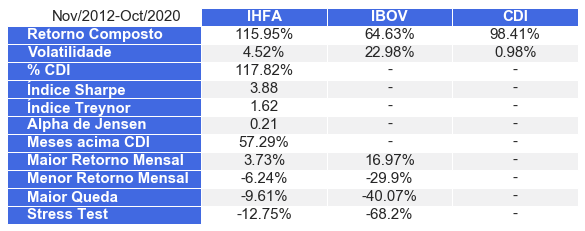

In [237]:
fig, ax = plt.subplots(figsize=(5, 1))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

header_color = 'royalblue'
row_colors = ['#f1f1f2', 'w']

tab = table(ax, df_sts, loc='upper left', cellLoc='center', colWidths=[0.30]*len(df_sts.columns))

# index name
w, h = tab[0,1].get_width(), tab[0,1].get_height()
tab.add_cell(0, -1, w, h, text=period)

#properties
tab.auto_set_font_size(False)
tab.set_fontsize(15)
tab.scale(1.5, 1.5)

#coloring
for k, cell in six.iteritems(tab._cells):
    cell.set_edgecolor('w')
        
    if k[0] == 0 and k[1] == -1:
        pass   
    elif k[0] == 0 or k[1] < 0:
        cell.set_text_props(weight='bold', color='w')
        cell.set_facecolor(header_color)
    else:
        cell.set_facecolor(row_colors[k[0]%len(row_colors)])

plt.savefig('retorno_tabela.png',dpi=300, bbox_inches = 'tight')